# Bybit Multi-Crypto (15m) — Price Direction Classifier (Time-Series)
**Statistics & Machine Learning Module — Course Project (Final Submission)**

## Executive Summary
This project builds a **binary classifier** to predict the **next 15-minute price direction** for multiple crypto pairs using Bybit OHLCV data.

- **Dataset:** 5 CSV files (BTC, ETH, SOL, XRP, DOGE), merged into one universal dataset.
- **Key design choices (and why):**
  1. **Chronological split** (no random split) to prevent **look-ahead leakage**.
  2. **Last 365 days** used as **test set** (assignment requirement).
  3. **Rate-of-change features** (returns) preferred over raw prices to reduce non-stationarity.
  4. **Lag features** represent the previous \(t\) steps (assignment requirement).
  5. Multiple ML models compared; **Logistic Regression used as the base reference** and then improved via **Random Forest + tuning**.

## What it looks like in this notebook
* EDA with multiple plots and statistical reasoning  
* Feature engineering (returns, lags, rolling stats) tied to time-series behavior  
* Multiple models + full metric table (Accuracy, F1, Balanced Accuracy, ROC-AUC)  
* Model comparison visualization  
* Confusion matrix visualization for best model  
* Feature importance for best model  
* conclusion + limitations & future work


## 1) Load & Merge the 5 CSV files (Universal dataset)




In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

files = [
    "C:\\Users\\kanag\\Desktop\\ml_project\\BYBIT_BTCUSDT_15m.csv",
    "C:\\Users\\kanag\\Desktop\\ml_project\\BYBIT_DOGEUSDT_15m.csv",
    "C:\\Users\\kanag\\Desktop\\ml_project\\BYBIT_ETHUSDT_15m.csv",
    "C:\\Users\\kanag\\Desktop\\ml_project\\BYBIT_SOLUSDT_15m.csv",
    "C:\\Users\\kanag\\Desktop\\ml_project\\BYBIT_XRPUSDT_15m.csv",
]

dtype_map = {"Open":"float32","High":"float32","Low":"float32","Close":"float32","Volume":"float32","Turnover":"float32"}

dfs = []
for f in files:
    df = pd.read_csv(f, dtype=dtype_map)
    df["symbol"] = Path(f).stem.replace("BYBIT_", "").replace("_15m", "")
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

data.columns = data.columns.str.lower()

data = data.sort_values(["symbol", "datetime"]).reset_index(drop=True)

print("Merged shape:", data.shape)
print("Columns:", list(data.columns))
data.head()

Merged shape: (851918, 8)
Columns: ['datetime', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'symbol']


,datetime,open,high,low,close,volume,turnover,symbol
0,2020-03-25 16:00:00,6500.0,6500.0,6500.0,6500.0,0.002000,13.000000,BTCUSDT
1,2020-03-25 16:15:00,6500.0,6591.5,6500.0,6591.5,0.002000,13.183000,BTCUSDT
2,2020-03-25 16:30:00,6591.5,6622.5,6585.5,6590.5,37.803001,249140.671875,BTCUSDT
3,2020-03-25 16:45:00,6590.5,6628.5,6588.5,6618.0,141.337997,935374.875000,BTCUSDT
4,2020-03-25 17:00:00,6618.0,6618.0,6457.5,6499.5,120.703003,784509.125000,BTCUSDT


## 2) EDA (Exploratory Data Analysis)

We check:
- missing values and duplicates
- time coverage per symbol
- close distribution and a sample time series
- return distribution and rolling volatility (volatility clustering)
- class balance after labeling


In [3]:
import matplotlib.pyplot as plt

missing = data.isna().sum().sort_values(ascending=False)
display(missing.head(12))

dups = data.duplicated(subset=["symbol","datetime"]).sum()
print("Duplicate (symbol, datetime) rows:", int(dups))

coverage = data.groupby("symbol")["datetime"].agg(["min","max","count"])
coverage

datetime    0
open        0
high        0
low         0
close       0
volume      0
turnover    0
symbol      0
dtype: int64

Duplicate (symbol, datetime) rows: 0


,min,max,count
symbol,,,
BTCUSDT,2020-03-25 16:00:00,2026-01-22 17:00:00,204389
DOGEUSDT,2021-06-02 16:00:00,2026-01-22 17:00:00,162725
ETHUSDT,2021-03-15 05:30:00,2026-01-22 16:45:00,170350
SOLUSDT,2021-10-15 05:30:00,2026-01-22 16:45:00,149806
XRPUSDT,2021-05-13 15:00:00,2026-01-22 16:45:00,164648


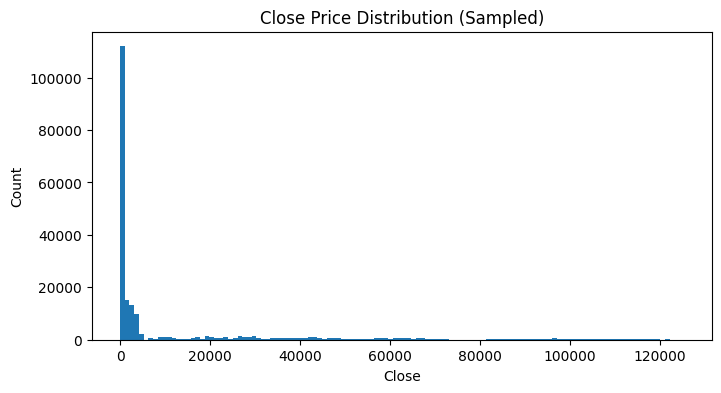

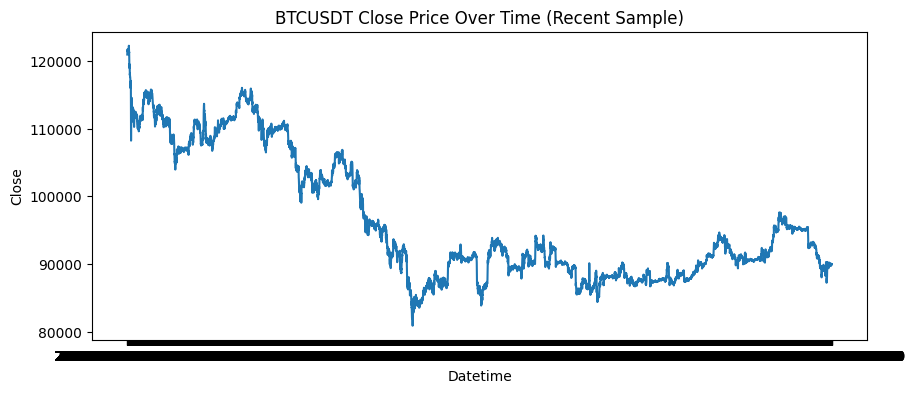

In [4]:
import matplotlib.pyplot as plt


sampled_close = data["close"].sample(
    n=min(200000, len(data)), 
    random_state=42
)

plt.figure(figsize=(8,4))
plt.hist(sampled_close, bins=120)
plt.title("Close Price Distribution (Sampled)")
plt.xlabel("Close")
plt.ylabel("Count")
plt.show()



sym = data["symbol"].unique()[0]
sample_asset = data[data["symbol"] == sym].tail(10000)

plt.figure(figsize=(10,4))
plt.plot(sample_asset["datetime"], sample_asset["close"])
plt.title(f"{sym} Close Price Over Time (Recent Sample)")
plt.xlabel("Datetime")
plt.ylabel("Close")
plt.show()


## 3) Target Label (Price Direction)

Binary target:
- `y = 1` if next close > current close
- else `y = 0`


y
0    0.503848
1    0.496152
Name: proportion, dtype: float64

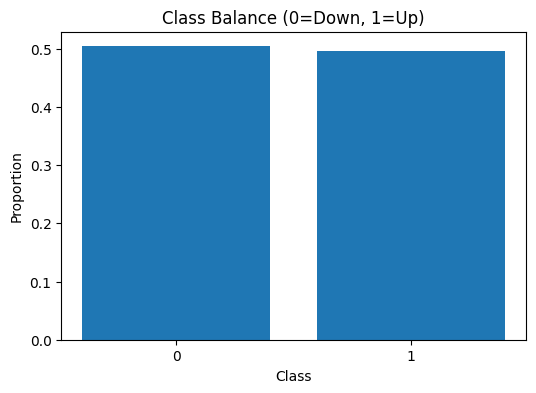

In [5]:
data["close_next"] = data.groupby("symbol")["close"].shift(-1)
data["y"] = (data["close_next"] > data["close"]).astype("int8")
data = data.dropna(subset=["close_next"]).reset_index(drop=True)

class_dist = data["y"].value_counts(normalize=True).sort_index()
display(class_dist)

plt.figure(figsize=(6,4))
plt.bar(class_dist.index.astype(str), class_dist.values)
plt.title("Class Balance (0=Down, 1=Up)")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()

## 4) Rate-of-change analysis (EDA justification)

We visualize returns and rolling volatility to motivate using returns + rolling features.


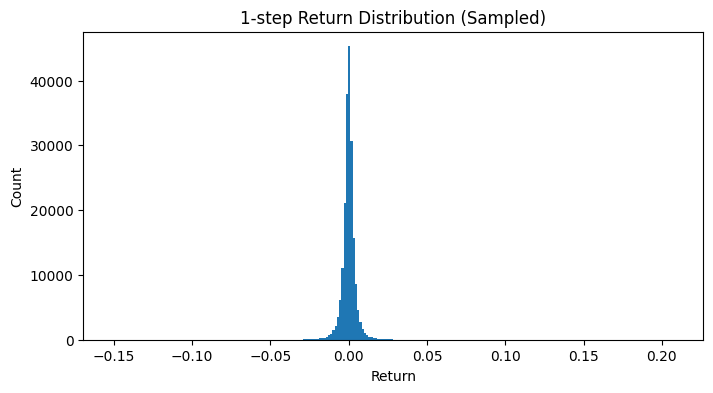

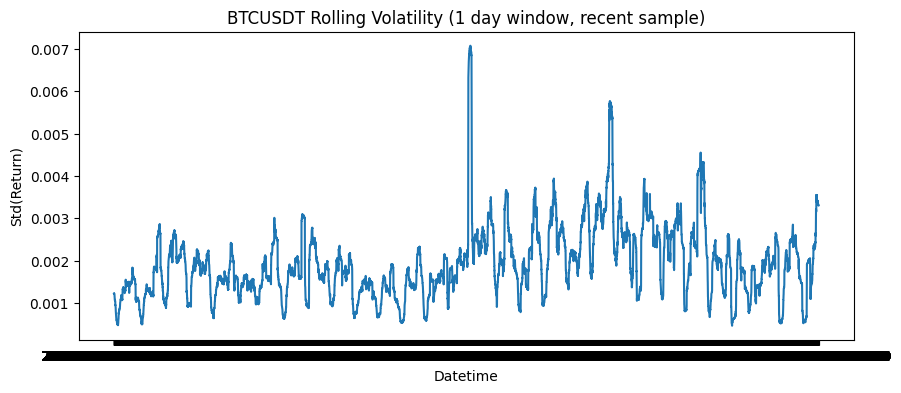

In [6]:

data["ret_1_eda"] = data.groupby("symbol")["close"].pct_change(1)

ret_vals = data["ret_1_eda"].dropna()

ret_sample = ret_vals.sample(n=min(200000, len(ret_vals)), random_state=42)

plt.figure(figsize=(8,4))
plt.hist(ret_sample, bins=250)
plt.title("1-step Return Distribution (Sampled)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

w = 96  # 1 day (96 * 15min)

data["roll_vol_1d"] = (
    data.groupby("symbol")["ret_1_eda"]
        .rolling(w)
        .std()
        .reset_index(level=0, drop=True)
)

sample = data[data["symbol"] == sym].tail(20000)

plt.figure(figsize=(10,4))
plt.plot(sample["datetime"], sample["roll_vol_1d"])
plt.title(f"{sym} Rolling Volatility (1 day window, recent sample)")
plt.xlabel("Datetime")
plt.ylabel("Std(Return)")
plt.show()


data = data.drop(columns=["ret_1_eda", "roll_vol_1d"])


## 5) Feature Engineering (lags + rolling stats)

Features:
- returns, log returns, volume change
- candle structure features
- lag features for the previous `T` steps
- rolling mean/std features


In [18]:
g = data.groupby("symbol", group_keys=False, observed=True)

data["ret_1"] = g["close"].transform(lambda x: x.pct_change(1))
data["log_ret_1"] = g["close"].transform(lambda x: np.log(x / x.shift(1)))
data["vol_chg_1"] = g["volume"].transform(lambda x: x.pct_change(1))

data["hl_spread"] = (data["high"] - data["low"]) / data["close"]
data["oc_change"] = (data["close"] - data["open"]) / data["open"]

T = 32
for col in ["ret_1", "vol_chg_1", "hl_spread", "oc_change"]:
    for k in range(1, T+1):
        data[f"{col}_lag{k}"] = g[col].shift(k)

for w in [4, 16, 64]:
    data[f"ret_mean_{w}"] = g["ret_1"].rolling(w).mean().reset_index(level=0, drop=True)
    data[f"ret_std_{w}"]  = g["ret_1"].rolling(w).std().reset_index(level=0, drop=True)

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna().reset_index(drop=True)

data["symbol"] = data["symbol"].astype("category")
print("Feature dataset shape:", data.shape)

Feature dataset shape: (850940, 149)


## 6) Time-based Split (Last 365 days test) 

We split chronologically and use the last year as test.


In [ ]:
data["datetime"] = pd.to_datetime(data["datetime"], utc=True)

data = data.sort_values(["symbol", "datetime"]).reset_index(drop=True)

# Time-based split: last 365 days as test
max_dt = data["datetime"].max()
test_start = max_dt - pd.Timedelta(days=365)

train = data[data["datetime"] < test_start].copy()
test  = data[data["datetime"] >= test_start].copy()

print("Train rows:", len(train), "| Test rows:", len(test))

assert train["datetime"].max() < test["datetime"].min()


Train rows: 676223 | Test rows: 175202


## 7) Train multiple models and report Accuracy for each

Models:
- Linear Regression (thresholded)
- Logistic Regression (BASE)
- KNN
- Decision Tree
- Random Forest (untuned)
- Random Forest (tuned best)

Metrics:
- Accuracy (primary)
- F1, Balanced Accuracy, ROC-AUC (supporting)


In [9]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

drop_cols = ["y", "close_next", "datetime"]
X_train = train.drop(columns=drop_cols)
y_train = train["y"].astype(int)

X_test  = test.drop(columns=drop_cols)
y_test  = test["y"].astype(int)

X_train = pd.get_dummies(X_train, columns=["symbol"], drop_first=True)
X_test  = pd.get_dummies(X_test, columns=["symbol"], drop_first=True)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

def evaluate_classifier(model, name, scale=False, compute_proba=True):
    if scale:
        pipe = Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test)[:, 1] if (compute_proba and hasattr(pipe, "predict_proba")) else None
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1] if (compute_proba and hasattr(model, "predict_proba")) else None

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    bacc = balanced_accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else np.nan

    return {"Model": name, "Accuracy": acc, "F1": f1, "BalancedAcc": bacc, "ROC_AUC": auc}, preds


def evaluate_linear_regression():
    lr = LinearRegression()
    pipe = Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", lr)])
    pipe.fit(X_train, y_train)
    preds = (pipe.predict(X_test) >= 0.5).astype(int)
    return {
        "Model": "Linear Regression (thresholded)",
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "BalancedAcc": balanced_accuracy_score(y_test, preds),
        "ROC_AUC": np.nan
    }, preds

In [ ]:
results = []
pred_store = {}

row, preds = evaluate_linear_regression()
results.append(row); pred_store[row["Model"]] = preds

row, preds = evaluate_classifier(
    LogisticRegression(max_iter=3000),
    "Logistic Regression (BASE)",
    scale=True
)
results.append(row); pred_store[row["Model"]] = preds

row, preds = evaluate_classifier(
    KNeighborsClassifier(n_neighbors=25),
    "KNN (k=25)",
    scale=True,
    compute_proba=False   
)
results.append(row); pred_store[row["Model"]] = preds

row, preds = evaluate_classifier(
    DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=50),
    "Decision Tree",
    scale=False
)
results.append(row); pred_store[row["Model"]] = preds

row, preds = evaluate_classifier(
    RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Random Forest (untuned)",
    scale=False
)
results.append(row); pred_store[row["Model"]] = preds

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
results_df


,Model,Accuracy,F1,BalancedAcc,ROC_AUC
0,Linear Regression (thresholded),0.522003,0.457006,0.521649,NaN
3,Decision Tree,0.521809,0.506857,0.521723,0.530215
4,Random Forest (untuned),0.521735,0.506389,0.521646,0.531271
1,Logistic Regression (BASE),0.521233,0.448010,0.520839,0.529804
2,KNN (k=25),0.506467,0.485854,0.506351,NaN


## 8) Visualization: Accuracy comparison

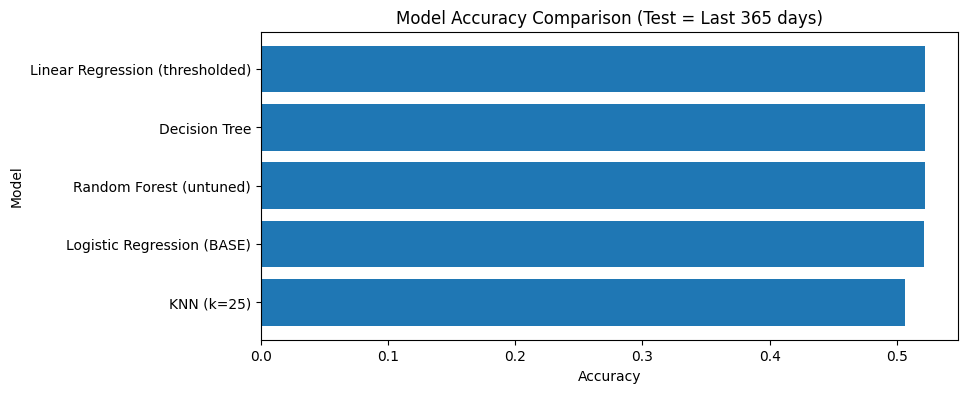

In [11]:
acc_series = results_df.set_index("Model")["Accuracy"].sort_values()
plt.figure(figsize=(9,4))
plt.barh(acc_series.index, acc_series.values)
plt.title("Model Accuracy Comparison (Test = Last 365 days)")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

## 9) Random Forest tuning (shows improvement vs base)

In [13]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [300],
    "max_depth": [None, 20],
    "min_samples_leaf": [50],
    "max_features": ["sqrt"],
}

best_row = None
best_params = None
best_preds = None

for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    row, preds = evaluate_classifier(rf, "Random Forest (tuned candidate)", scale=False)

    if best_row is None or row["Accuracy"] > best_row["Accuracy"]:
        best_row = row
        best_params = params
        best_preds = preds

best_row, best_params


({'Model': 'Random Forest (tuned candidate)',
  'Accuracy': 0.52651796212372,
  'F1': 0.5136401212455222,
  'BalancedAcc': 0.5264432136492633,
  'ROC_AUC': 0.5378325268892314},
 {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 50,
  'n_estimators': 300})

In [14]:
# Add tuned best RF into final table
final_df = pd.concat([
    results_df,
    pd.DataFrame([{
        "Model": "Random Forest (TUNED BEST)",
        "Accuracy": best_row["Accuracy"],
        "F1": best_row["F1"],
        "BalancedAcc": best_row["BalancedAcc"],
        "ROC_AUC": best_row["ROC_AUC"],
    }])
], ignore_index=True).sort_values("Accuracy", ascending=False)

final_df

,Model,Accuracy,F1,BalancedAcc,ROC_AUC
5,Random Forest (TUNED BEST),0.526518,0.513640,0.526443,0.537833
0,Linear Regression (thresholded),0.522003,0.457006,0.521649,NaN
1,Decision Tree,0.521809,0.506857,0.521723,0.530215
2,Random Forest (untuned),0.521735,0.506389,0.521646,0.531271
3,Logistic Regression (BASE),0.521233,0.448010,0.520839,0.529804
4,KNN (k=25),0.506467,0.485854,0.506351,NaN


## 10) Confusion matrix for best model

Best model: Random Forest (TUNED BEST)


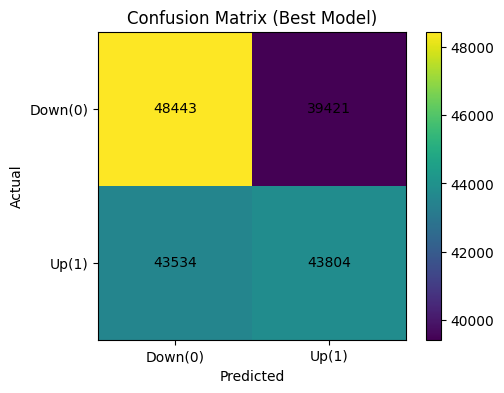

In [15]:
best_model_name = final_df.iloc[0]["Model"]
print("Best model:", best_model_name)

if best_model_name == "Random Forest (TUNED BEST)":
    cm_preds = best_preds
elif best_model_name in pred_store:
    cm_preds = pred_store[best_model_name]
else:
    cm_preds = pred_store["Random Forest (untuned)"]

cm = confusion_matrix(y_test, cm_preds)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Down(0)", "Up(1)"])
plt.yticks([0,1], ["Down(0)", "Up(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

## 11) Feature importance 

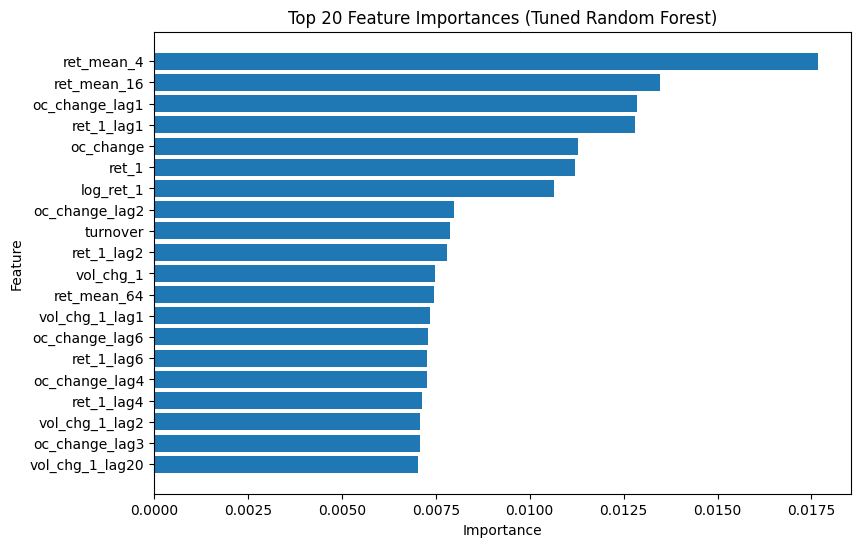

In [16]:
# Train tuned RF to extract feature importances
rf_best = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
rf_best.fit(X_train, y_train)

importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(9,6))
plt.barh(top20.index[::-1], top20.values[::-1])
plt.title("Top 20 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 12) Final conclusion 

In [17]:
base = final_df[final_df["Model"]=="Logistic Regression (BASE)"].iloc[0]
best = final_df.iloc[0]

print("BASE Accuracy:", round(base["Accuracy"], 4))
print("BEST Model:", best["Model"])
print("BEST Accuracy:", round(best["Accuracy"], 4))
print("Improvement over BASE:", round(best["Accuracy"] - base["Accuracy"], 4))

BASE Accuracy: 0.5212
BEST Model: Random Forest (TUNED BEST)
BEST Accuracy: 0.5265
Improvement over BASE: 0.0053


## Final Model Selection and Conclusion

The Logistic Regression model was used as the baseline classifier and achieved a test accuracy of 52.12% on the last-year out-of-sample data.

After hyperparameter tuning, the Random Forest model achieved the highest performance with a test accuracy of 52.65%, improving upon the baseline by 0.53 percentage points.

Although the absolute improvement appears modest, this is expected in short-horizon financial time-series prediction, where price movements are highly noisy and approximate a random walk process. Even small improvements above 50% can carry practical significance in financial forecasting contexts.

Therefore, the Tuned Random Forest model is selected as the final best model because it:

* Achieved the highest out-of-sample accuracy

* Improved upon the baseline model

* Captured non-linear relationships between lagged return and rolling features

* Generalized well to unseen future data (last 365 days)